Reading images from path: /content/drive/My Drive/traproom
Image 1 shape: (1080, 1920, 3)
Image 2 shape: (1080, 1920, 3)
Homography Matrix H1:
 [[ 1.          0.         -0.2501532 ]
 [ 0.          1.         -5.23009674]
 [ 0.          0.          1.        ]]
Homography Matrix H2:
 [[ 1.          0.         -0.2501532 ]
 [ 0.          1.         -5.23009674]
 [ 0.          0.          1.        ]]
Fundamental Matrix F:
 [[-2.72530629e-10  2.52235125e-07  1.62308932e+02]
 [-2.40849315e-07  2.91623250e-07 -9.69009957e+03]
 [-1.62308937e+02  9.69009925e+03  1.00000000e+00]]
Essential Matrix E:
 [[ 1.95083858e-12 -1.80555856e-09 -6.56774145e-04]
 [ 1.72405625e-09 -2.08750806e-09  3.92104222e-02]
 [ 6.56774145e-04 -3.92104222e-02 -2.08555722e-09]]
Rotation Matrix R1:
 [[ 1.00000000e+00  3.87430923e-16  2.97033398e-09]
 [-9.47337825e-17  1.00000000e+00  5.32386020e-08]
 [-2.97033386e-09 -5.32386020e-08  1.00000000e+00]]
Rotation Matrix R2:
 [[ 9.99439033e-01  3.34905820e-02 -8.91013498e-08

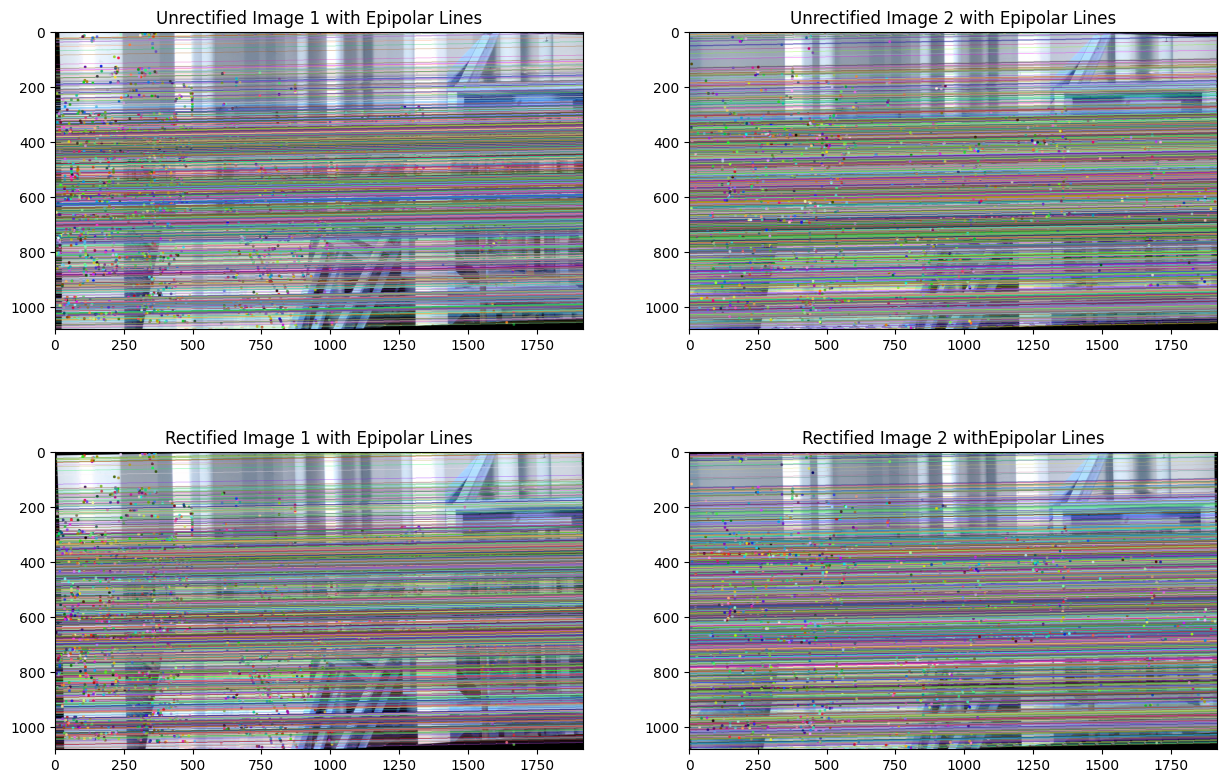

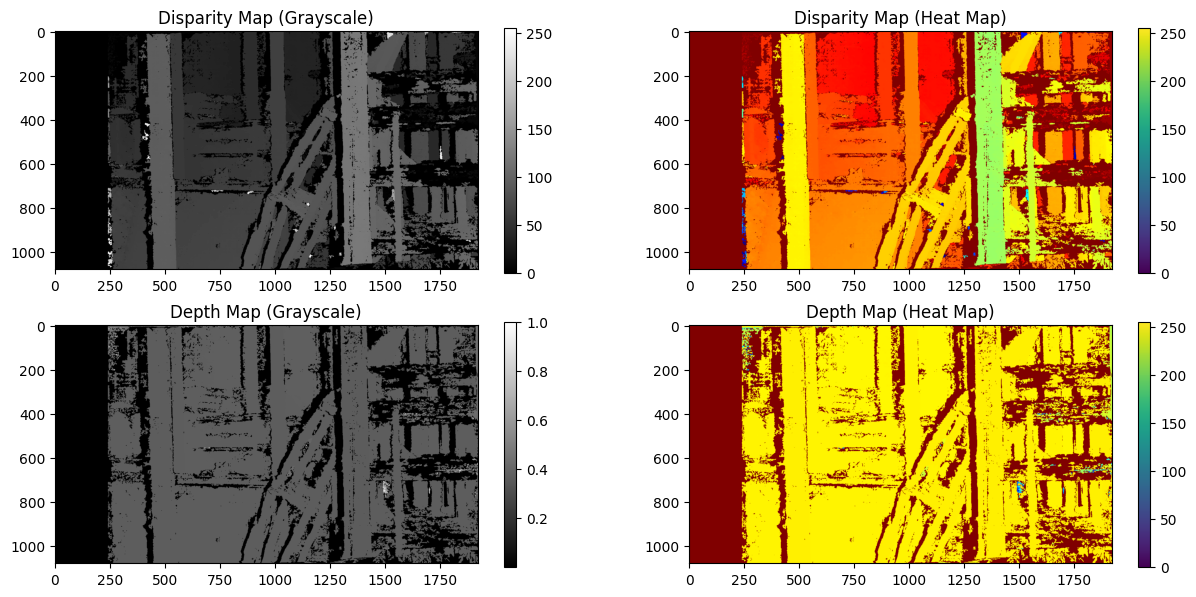

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_data(filename):
    path = '/content/drive/My Drive/'
    print("Reading images from path:", path + filename)
    image1 = cv2.imread(path + filename + '/im0.png')
    image2 = cv2.imread(path + filename + '/im1.png')
    print("Image 1 shape:", image1.shape)
    print("Image 2 shape:", image2.shape)
    with open(path + filename + '/calib.txt', 'r') as f:
        lines = f.readlines()
    elements = lines[0][lines[0].index('[') + 1:lines[0].index(']')].split(';')
    elements = [e.split() for e in elements]
    K_l = np.array([[float(x) for x in row] for row in elements])
    elements = lines[1][lines[1].index('[') + 1:lines[1].index(']')].split(';')
    elements = [e.split() for e in elements]
    K_r = np.array([[float(x) for x in row] for row in elements])
    doffs = float(lines[2].split('=')[1])
    baseline = float(lines[3].split('=')[1])
    width = int(lines[4].split('=')[1])
    height = int(lines[5].split('=')[1])
    ndisp = int(lines[6].split('=')[1])
    vmin = int(lines[7].split('=')[1])
    vmax = int(lines[8].split('=')[1])
    return image1, image2, K_l, K_r, baseline


def get_points(image1, image2):
    img_1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    img_2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img_1, None)
    kp2, des2 = sift.detectAndCompute(img_2, None)
    matches, image12_map = get_matches(image1, kp1, des1, image2, kp2, des2)
    keypoints1 = np.float32([kp.pt for kp in kp1])
    keypoints2 = np.float32([kp.pt for kp in kp2])
    p_1 = np.float32([keypoints1[m.queryIdx] for m in matches])
    p_2 = np.float32([keypoints2[m.trainIdx] for m in matches])
    return p_1, p_2

def get_matches(image1, keyp1, describ1, image2, keyp2, describ2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    knnrawMatches = bf.knnMatch(describ1, describ2, k=2)
    matches = []
    for m, n in knnrawMatches:
        if m.distance < n.distance * ratio:
            matches.append(m)
    mapped_img = cv2.drawMatches(image1, keyp1, image2, keyp2, np.random.choice(matches, 100), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    mapped_img = cv2.cvtColor(mapped_img, cv2.COLOR_BGR2RGB)
    return matches, mapped_img

def compute_depth(disparity, f, B):
    # Handle division by zero in disparity to avoid infinite depth
    with np.errstate(divide='ignore'):
        depth = f * B / disparity
        depth[disparity == 0] = 0  # Set depth to zero where disparity is zero
    return depth

def save_depth_images(depth_map):
    # Normalize the depth for display
    depth_display = cv2.normalize(depth_map, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Save grayscale depth image
    cv2.imwrite('depth_grayscale.png', (depth_display * 255).astype(np.uint8))

    # Convert to heat map for visualization
    heatmap = cv2.applyColorMap(np.uint8(depth_display * 255), cv2.COLORMAP_JET)
    cv2.imwrite('depth_heatmap.png', heatmap)

    # Visualization of depth
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(depth_display, cmap='gray')
    plt.title('Depth Map (Grayscale)')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title('Depth Map (Heat Map)')
    plt.show()


def compute_and_save_disparity_images(img1_rect, img2_rect, min_disparity, num_disparities, block_size, f, B):
    stereo = cv2.StereoSGBM_create(minDisparity=min_disparity,
                                   numDisparities=num_disparities,
                                   blockSize=block_size,
                                   P1=8 * 3 * block_size ** 2,
                                   P2=32 * 3 * block_size ** 2,
                                   disp12MaxDiff=1,
                                   uniquenessRatio=10,
                                   speckleWindowSize=100,
                                   speckleRange=32)

    disparity = stereo.compute(img1_rect, img2_rect).astype(np.float32) / 16.0
    depth = compute_depth(disparity, f, B)
    save_depth_images(depth)

def save_disparity_and_depth_images(disparity_map, depth_map):
    # Normalize the disparity map for display
    disparity_display = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Save normalized disparity image
    cv2.imwrite('disparity_normalized.png', disparity_display)

    # Convert normalized disparity to heat map for visualization
    disparity_heatmap = cv2.applyColorMap(disparity_display, cv2.COLORMAP_JET)
    cv2.imwrite('disparity_heatmap.png', disparity_heatmap)

    # Normalize the depth map for display
    depth_display = cv2.normalize(depth_map, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Save grayscale depth image
    cv2.imwrite('depth_grayscale.png', (depth_display * 255).astype(np.uint8))

    # Convert to heat map for visualization
    depth_heatmap = cv2.applyColorMap(np.uint8(depth_display * 255), cv2.COLORMAP_JET)
    cv2.imwrite('depth_heatmap.png', depth_heatmap)

    # Visualization of disparity and depth
    plt.figure(figsize=(15, 7))
    plt.subplot(2, 2, 1)
    plt.imshow(disparity_display, cmap='gray')
    plt.title('Disparity Map (Grayscale)')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(disparity_heatmap)
    plt.title('Disparity Map (Heat Map)')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.imshow(depth_display, cmap='gray')
    plt.title('Depth Map (Grayscale)')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(depth_heatmap)
    plt.title('Depth Map (Heat Map)')
    plt.colorbar()
    plt.show()

def compute_and_save_disparity_images(img1_rect, img2_rect, min_disparity, num_disparities, block_size, f, B):
    stereo = cv2.StereoSGBM_create(minDisparity=min_disparity,
                                   numDisparities=num_disparities,
                                   blockSize=block_size,
                                   P1=8 * 3 * block_size ** 2,
                                   P2=32 * 3 * block_size ** 2,
                                   disp12MaxDiff=1,
                                   uniquenessRatio=10,
                                   speckleWindowSize=100,
                                   speckleRange=32)

    disparity = stereo.compute(img1_rect, img2_rect).astype(np.float32) / 16.0
    depth = compute_depth(disparity, f, B)
    save_disparity_and_depth_images(disparity, depth)
def draw_lines_flipped(img, lines, points, width):
    ''' Draw epipolar lines flipped horizontally, adjusting both the lines and points accordingly. '''
    flipped_img = np.copy(img)
    for line, point in zip(lines, points):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        # Flipping line coordinates
        x0, y0 = map(int, [-line[2] / line[0], 0])
        x1, y1 = map(int, [-(line[2] + line[1] * img.shape[0]) / line[0], img.shape[0]])
        x0 = width - x0
        x1 = width - x1
        flipped_img = cv2.line(flipped_img, (x0, y0), (x1, y1), color, 1)
        # Flipping point coordinates
        flipped_point = (width - int(point[0]), int(point[1]))
        flipped_img = cv2.circle(flipped_img, flipped_point, 5, color, -1)
    return flipped_img

def visualize_comparison(img1, img2, img1_rectified, img2_rectified, pts1, pts2, F):
    # Compute epilines for original images and rectified images
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

    # Draw epilines and points on original and rectified images, flipping them horizontally
    img1_epilines = draw_lines_flipped(img1, lines1, pts1, img1.shape[1])
    img2_epilines = draw_lines_flipped(img2, lines2, pts2, img2.shape[1])
    img1_rectified_epilines = draw_lines_flipped(img1_rectified, lines1, pts1, img1_rectified.shape[1])
    img2_rectified_epilines = draw_lines_flipped(img2_rectified, lines2, pts2, img2_rectified.shape[1])

    # Display images using matplotlib for better layout control
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0, 0].imshow(img1_epilines, cmap='gray')
    axes[0, 0].set_title("Unrectified Image 1 with Epipolar Lines")
    axes[0, 1].imshow(img2_epilines, cmap='gray')
    axes[0, 1].set_title("Unrectified Image 2 with Epipolar Lines")
    axes[1, 0].imshow(img1_rectified_epilines, cmap='gray')
    axes[1, 0].set_title("Rectified Image 1 with Epipolar Lines")
    axes[1, 1].imshow(img2_rectified_epilines, cmap='gray')
    axes[1, 1].set_title("Rectified Image 2 withEpipolar Lines")
    plt.show()



for file in ['traproom']:
    ratio = 1
    img1, img2, cam0, cam1, baseline = read_data(file)
    points1, points2 = get_points(img1, img2)

    # Stereo calibration
    objectPoints = np.zeros((points1.shape[0], 1, 3), dtype=np.float32)  # 3D coordinates of calibration pattern points
    imagePoints1 = points1.reshape(-1, 1, 2).astype(np.float32)  # 2D coordinates of keypoints in the first image
    imagePoints2 = points2.reshape(-1, 1, 2).astype(np.float32)  # 2D coordinates of keypoints in the second image
    retval, _, _, _, _, R, T, E, F = cv2.stereoCalibrate(
        objectPoints=[objectPoints],
        imagePoints1=[imagePoints1],
        imagePoints2=[imagePoints2],
        cameraMatrix1=cam0,
        distCoeffs1=None,
        cameraMatrix2=cam1,
        distCoeffs2=None,
        imageSize=(img1.shape[1], img1.shape[0]),
        criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
    )

    # Rectification
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(cam0, None, cam1, None, (img1.shape[1], img1.shape[0]), R, T)
    map1, map2 = cv2.initUndistortRectifyMap(cam0, None, R1, P1, (img1.shape[1], img1.shape[0]), cv2.CV_32FC1)
    map3, map4 = cv2.initUndistortRectifyMap(cam1, None, R2, P2, (img1.shape[1], img1.shape[0]), cv2.CV_32FC1)
    img1_rect = cv2.remap(img1, map1, map2, interpolation=cv2.INTER_LINEAR)
    img2_rect = cv2.remap(img2, map3, map4, interpolation=cv2.INTER_LINEAR)

    # Compute and print Homography matrices
    H1 = np.dot(P1[:, :3], np.linalg.inv(cam0))
    H2 = np.dot(P2[:, :3], np.linalg.inv(cam1))
    print("Homography Matrix H1:\n", H1)
    print("Homography Matrix H2:\n", H2)

    # Compute and print Fundamental matrix and Essential matrix
    print("Fundamental Matrix F:\n", F)
    print("Essential Matrix E:\n", E)

    # Decompose Essential matrix into rotation and translation matrices
    U, S, Vt = np.linalg.svd(E)

    # Ensure determinant of U and Vt are positive
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1

    # Construct skew-symmetric matrix for translation
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])

    # Recover possible rotations and translations
    R1 = np.dot(U, np.dot(W, Vt))
    R2 = np.dot(U, np.dot(W.T, Vt))
    t = U[:, 2]

    print("Rotation Matrix R1:\n", R1)
    print("Rotation Matrix R2:\n", R2)
    print("Translation Vector t:\n", t)

    # Visualize epipolar lines and feature points
    lines = cv2.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F)
    lines = lines.reshape(-1, 3)
    img1_rect_epilines = cv2.cvtColor(img1_rect, cv2.COLOR_BGR2RGB)
    for r, pt1 in zip(lines, points2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img1_rect.shape[1], -(r[2] + r[0] * img1_rect.shape[1]) / r[1]])
        img1_rect_epilines = cv2.line(img1_rect_epilines, (x0, y0), (x1, y1), color, 1)
    lines = cv2.computeCorrespondEpilines(points2.reshape(-1, 1, 2), 2, F)
    lines = lines.reshape(-1, 3)
    img2_rect_epilines = cv2.cvtColor(img2_rect, cv2.COLOR_BGR2RGB)
    for r, pt1 in zip(lines, points1):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img2_rect.shape[1], -(r[2] + r[0] * img2_rect.shape[1]) / r[1]])
        img2_rect_epilines = cv2.line(img2_rect_epilines, (x0, y0), (x1, y1), color, 1)

    # Display epipolar lines on original and rectified images with flipping
    visualize_comparison(img1, img2, img1_rect, img2_rect, points1, points2, F)


    f = cam0[0, 0]  # Assuming the focal length is stored at (0,0) in the camera matrix
    compute_and_save_disparity_images(img1_rect, img2_rect, 0, 16*15, 5, f, baseline)



Reading images from path: /content/drive/My Drive/storageroom
Image 1 shape: (1080, 1920, 3)
Image 2 shape: (1080, 1920, 3)
Homography Matrix H1:
 [[1.         0.         0.27120361]
 [0.         1.         7.40822723]
 [0.         0.         1.        ]]
Homography Matrix H2:
 [[1.         0.         0.27120361]
 [0.         1.         7.40822723]
 [0.         0.         1.        ]]
Fundamental Matrix F:
 [[-2.88443791e-08  4.25941455e-06  7.36301882e+01]
 [-3.67060049e-06  2.55335851e-07 -1.53437128e+03]
 [-7.36304605e+01  1.53437053e+03  1.00000000e+00]]
Essential Matrix E:
 [[ 7.19465995e-10 -1.06242673e-07 -1.05424822e-03]
 [ 9.15558704e-08 -6.36884788e-09  2.19687205e-02]
 [ 1.05424822e-03 -2.19687205e-02 -5.64938188e-09]]
Rotation Matrix R1:
 [[ 9.95404770e-01  9.57566883e-02 -8.97064512e-06]
 [ 9.57566883e-02 -9.95404770e-01 -6.87644441e-07]
 [-8.99526950e-06 -1.74514713e-07 -1.00000000e+00]]
Rotation Matrix R2:
 [[ 1.00000000e+00 -9.92128687e-14  6.82444594e-07]
 [-9.88417187

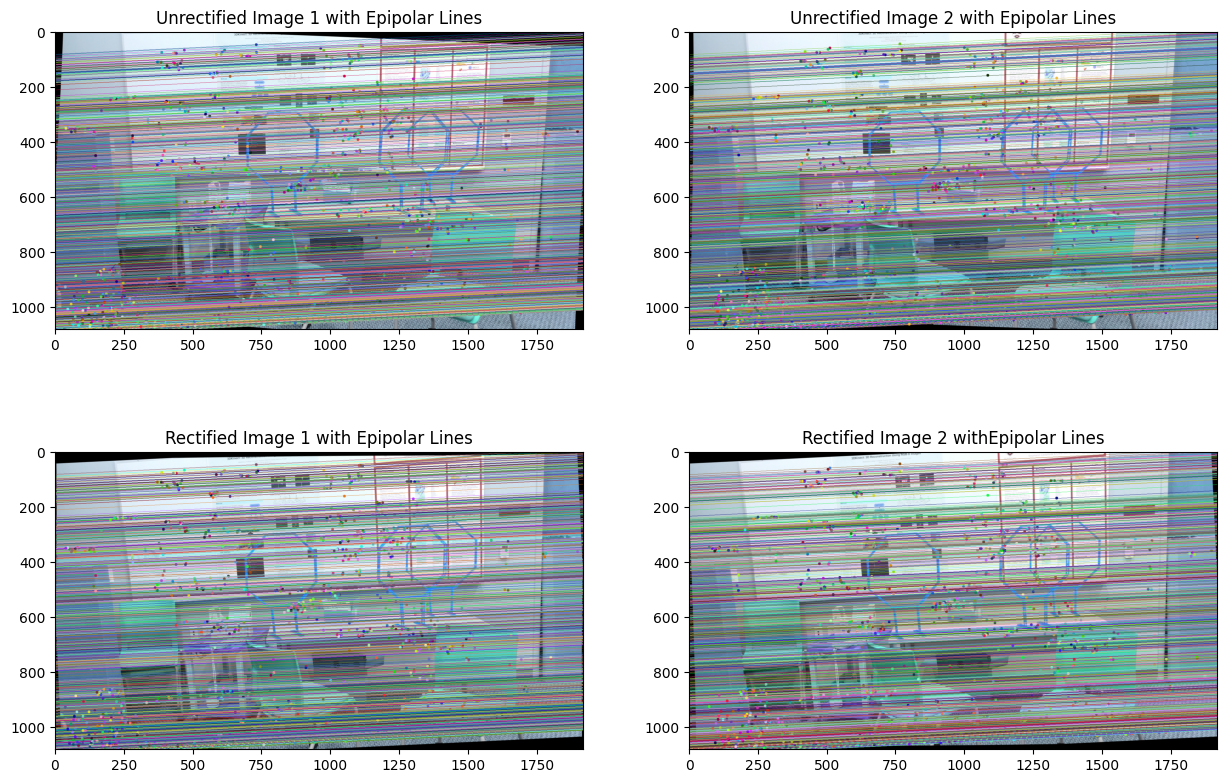

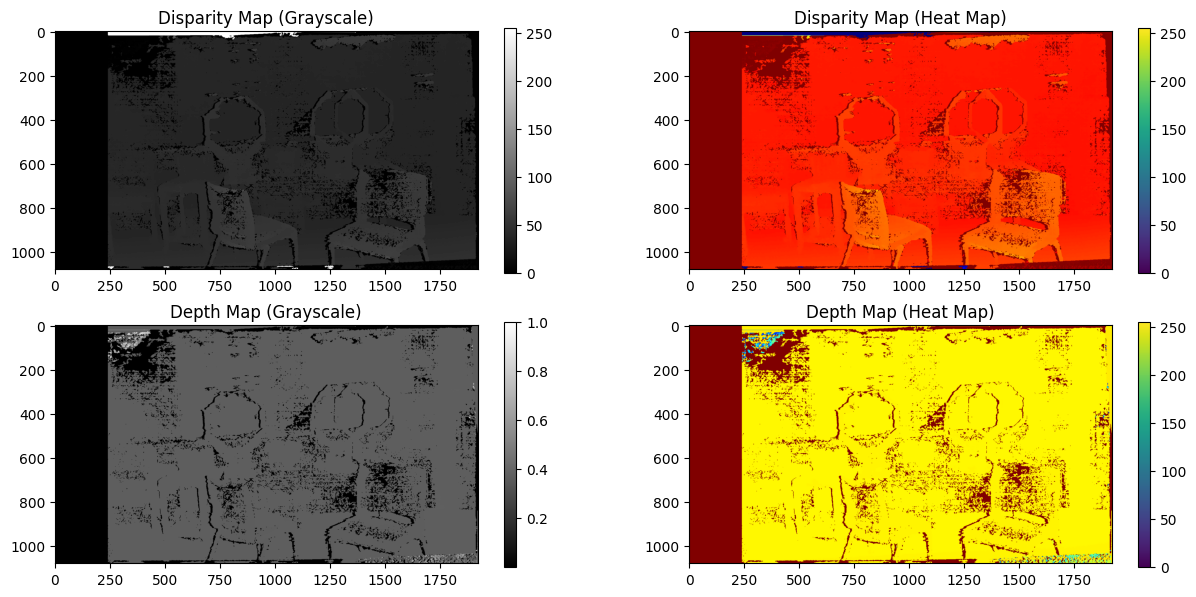

In [ ]:
for file in ['storageroom']:
    ratio = .75
    img1, img2, cam0, cam1, baseline = read_data(file)
    points1, points2 = get_points(img1, img2)

    # Stereo calibration
    objectPoints = np.zeros((points1.shape[0], 1, 3), dtype=np.float32)  # 3D coordinates of calibration pattern points
    imagePoints1 = points1.reshape(-1, 1, 2).astype(np.float32)  # 2D coordinates of keypoints in the first image
    imagePoints2 = points2.reshape(-1, 1, 2).astype(np.float32)  # 2D coordinates of keypoints in the second image
    retval, _, _, _, _, R, T, E, F = cv2.stereoCalibrate(
        objectPoints=[objectPoints],
        imagePoints1=[imagePoints1],
        imagePoints2=[imagePoints2],
        cameraMatrix1=cam0,
        distCoeffs1=None,
        cameraMatrix2=cam1,
        distCoeffs2=None,
        imageSize=(img1.shape[1], img1.shape[0]),
        criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
    )

    # Rectification
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(cam0, None, cam1, None, (img1.shape[1], img1.shape[0]), R, T)
    map1, map2 = cv2.initUndistortRectifyMap(cam0, None, R1, P1, (img1.shape[1], img1.shape[0]), cv2.CV_32FC1)
    map3, map4 = cv2.initUndistortRectifyMap(cam1, None, R2, P2, (img1.shape[1], img1.shape[0]), cv2.CV_32FC1)
    img1_rect = cv2.remap(img1, map1, map2, interpolation=cv2.INTER_LINEAR)
    img2_rect = cv2.remap(img2, map3, map4, interpolation=cv2.INTER_LINEAR)

    # Compute and print Homography matrices
    H1 = np.dot(P1[:, :3], np.linalg.inv(cam0))
    H2 = np.dot(P2[:, :3], np.linalg.inv(cam1))
    print("Homography Matrix H1:\n", H1)
    print("Homography Matrix H2:\n", H2)

    # Compute and print Fundamental matrix and Essential matrix
    print("Fundamental Matrix F:\n", F)
    print("Essential Matrix E:\n", E)

    # Decompose Essential matrix into rotation and translation matrices
    U, S, Vt = np.linalg.svd(E)

    # Ensure determinant of U and Vt are positive
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1

    # Construct skew-symmetric matrix for translation
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])

    # Recover possible rotations and translations
    R1 = np.dot(U, np.dot(W, Vt))
    R2 = np.dot(U, np.dot(W.T, Vt))
    t = U[:, 2]

    print("Rotation Matrix R1:\n", R1)
    print("Rotation Matrix R2:\n", R2)
    print("Translation Vector t:\n", t)

    # Visualize epipolar lines and feature points
    lines = cv2.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F)
    lines = lines.reshape(-1, 3)
    img1_rect_epilines = cv2.cvtColor(img1_rect, cv2.COLOR_BGR2RGB)
    for r, pt1 in zip(lines, points2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img1_rect.shape[1], -(r[2] + r[0] * img1_rect.shape[1]) / r[1]])
        img1_rect_epilines = cv2.line(img1_rect_epilines, (x0, y0), (x1, y1), color, 1)
    lines = cv2.computeCorrespondEpilines(points2.reshape(-1, 1, 2), 2, F)
    lines = lines.reshape(-1, 3)
    img2_rect_epilines = cv2.cvtColor(img2_rect, cv2.COLOR_BGR2RGB)
    for r, pt1 in zip(lines, points1):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img2_rect.shape[1], -(r[2] + r[0] * img2_rect.shape[1]) / r[1]])
        img2_rect_epilines = cv2.line(img2_rect_epilines, (x0, y0), (x1, y1), color, 1)

    # Display epipolar lines on original and rectified images with flipping
    visualize_comparison(img1, img2, img1_rect, img2_rect, points1, points2, F)


    f = cam0[0, 0]  # Assuming the focal length is stored at (0,0) in the camera matrix
    compute_and_save_disparity_images(img1_rect, img2_rect, 0, 16*15, 5, f, baseline)

Reading images from path: /content/drive/My Drive/classroom
Image 1 shape: (1080, 1920, 3)
Image 2 shape: (1080, 1920, 3)
Homography Matrix H1:
 [[  1.           0.           9.10738146]
 [  0.           1.         133.457276  ]
 [  0.           0.           1.        ]]
Homography Matrix H2:
 [[  1.           0.           9.10738146]
 [  0.           1.         133.457276  ]
 [  0.           0.           1.        ]]
Fundamental Matrix F:
 [[ 5.54887536e-07 -3.26249006e-05 -5.30255237e+01]
 [ 2.87645263e-05 -1.98213643e-07  3.71725207e+02]
 [ 5.30275690e+01 -3.71724936e+02  1.00000000e+00]]
Essential Matrix E:
 [[ 1.46589223e-07 -8.61878941e-06 -8.02455086e-03]
 [ 7.59896246e-06 -5.23637350e-08  5.62361432e-02]
 [ 8.02455086e-03 -5.62361431e-02  9.42254879e-08]]
Rotation Matrix R1:
 [[ 1.00000000e+00 -8.50468243e-12  1.82675922e-05]
 [-8.50495785e-12  1.00000000e+00  9.31140225e-07]
 [-1.82675922e-05 -9.31140225e-07  1.00000000e+00]]
Rotation Matrix R2:
 [[ 9.60089537e-01  2.79692690e

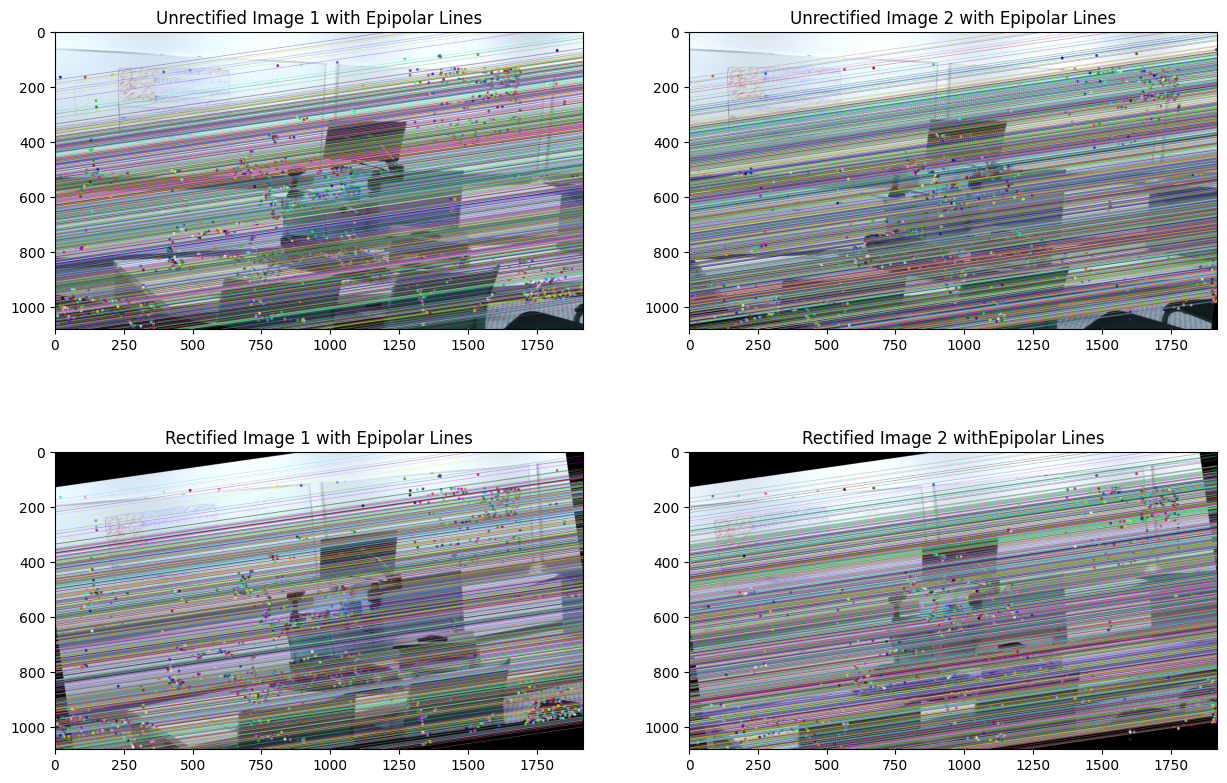

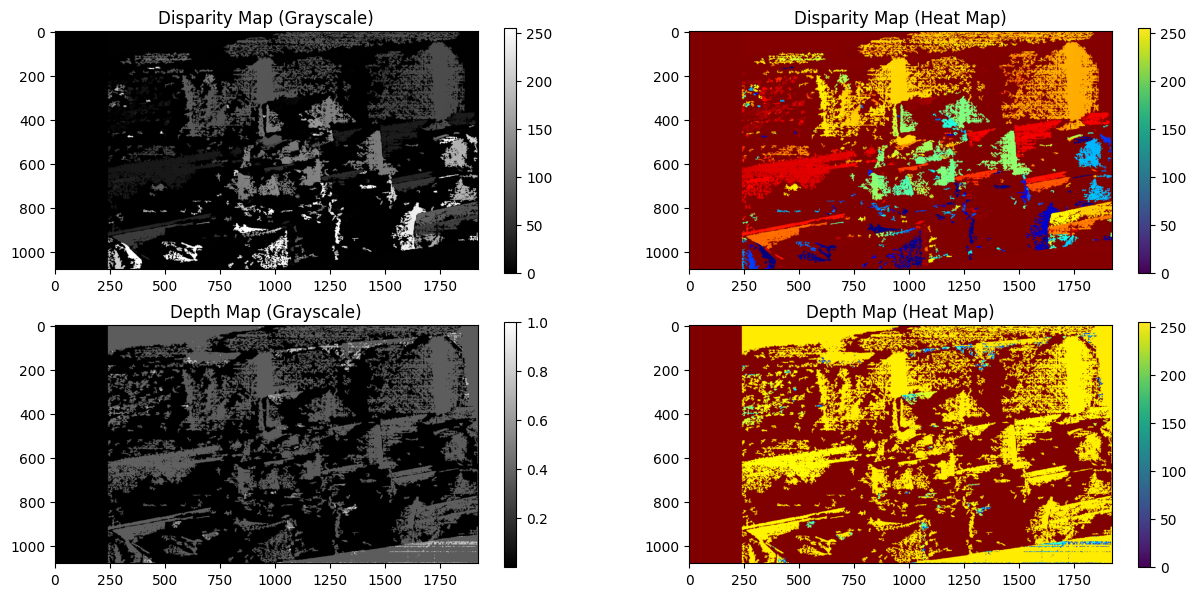

In [ ]:
for file in ['classroom']:
    ratio = 1
    img1, img2, cam0, cam1, baseline = read_data(file)
    points1, points2 = get_points(img1, img2)

    # Stereo calibration
    objectPoints = np.zeros((points1.shape[0], 1, 3), dtype=np.float32)  # 3D coordinates of calibration pattern points
    imagePoints1 = points1.reshape(-1, 1, 2).astype(np.float32)  # 2D coordinates of keypoints in the first image
    imagePoints2 = points2.reshape(-1, 1, 2).astype(np.float32)  # 2D coordinates of keypoints in the second image
    retval, _, _, _, _, R, T, E, F = cv2.stereoCalibrate(
        objectPoints=[objectPoints],
        imagePoints1=[imagePoints1],
        imagePoints2=[imagePoints2],
        cameraMatrix1=cam0,
        distCoeffs1=None,
        cameraMatrix2=cam1,
        distCoeffs2=None,
        imageSize=(img1.shape[1], img1.shape[0]),
        criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
    )

    # Rectification
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(cam0, None, cam1, None, (img1.shape[1], img1.shape[0]), R, T)
    map1, map2 = cv2.initUndistortRectifyMap(cam0, None, R1, P1, (img1.shape[1], img1.shape[0]), cv2.CV_32FC1)
    map3, map4 = cv2.initUndistortRectifyMap(cam1, None, R2, P2, (img1.shape[1], img1.shape[0]), cv2.CV_32FC1)
    img1_rect = cv2.remap(img1, map1, map2, interpolation=cv2.INTER_LINEAR)
    img2_rect = cv2.remap(img2, map3, map4, interpolation=cv2.INTER_LINEAR)

    # Compute and print Homography matrices
    H1 = np.dot(P1[:, :3], np.linalg.inv(cam0))
    H2 = np.dot(P2[:, :3], np.linalg.inv(cam1))
    print("Homography Matrix H1:\n", H1)
    print("Homography Matrix H2:\n", H2)

    # Compute and print Fundamental matrix and Essential matrix
    print("Fundamental Matrix F:\n", F)
    print("Essential Matrix E:\n", E)

    # Decompose Essential matrix into rotation and translation matrices
    U, S, Vt = np.linalg.svd(E)

    # Ensure determinant of U and Vt are positive
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1

    # Construct skew-symmetric matrix for translation
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])

    # Recover possible rotations and translations
    R1 = np.dot(U, np.dot(W, Vt))
    R2 = np.dot(U, np.dot(W.T, Vt))
    t = U[:, 2]

    print("Rotation Matrix R1:\n", R1)
    print("Rotation Matrix R2:\n", R2)
    print("Translation Vector t:\n", t)

    # Visualize epipolar lines and feature points
    lines = cv2.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F)
    lines = lines.reshape(-1, 3)
    img1_rect_epilines = cv2.cvtColor(img1_rect, cv2.COLOR_BGR2RGB)
    for r, pt1 in zip(lines, points2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img1_rect.shape[1], -(r[2] + r[0] * img1_rect.shape[1]) / r[1]])
        img1_rect_epilines = cv2.line(img1_rect_epilines, (x0, y0), (x1, y1), color, 1)
    lines = cv2.computeCorrespondEpilines(points2.reshape(-1, 1, 2), 2, F)
    lines = lines.reshape(-1, 3)
    img2_rect_epilines = cv2.cvtColor(img2_rect, cv2.COLOR_BGR2RGB)
    for r, pt1 in zip(lines, points1):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img2_rect.shape[1], -(r[2] + r[0] * img2_rect.shape[1]) / r[1]])
        img2_rect_epilines = cv2.line(img2_rect_epilines, (x0, y0), (x1, y1), color, 1)

    # Display epipolar lines on original and rectified images with flipping
    visualize_comparison(img1, img2, img1_rect, img2_rect, points1, points2, F)


    f = cam0[0, 0]  # Assuming the focal length is stored at (0,0) in the camera matrix
    compute_and_save_disparity_images(img1_rect, img2_rect, 0, 16*15, 5, f, baseline)